<a href="https://colab.research.google.com/github/benreeves/pydata-calgary/blob/master/Bayesian-Series/Applied-MCMC/web_traffic_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied MCMC with PyMC3 | PyData Calgary
In this notebook, we simulate some possible website traffic data. We then use Markov Chain Monte Carlo (MCMC) with the pymc3 library to show how we can make hypotheses about our data generation process and gather insight.

Our process is as follows:
- Generate our simulated website traffic data
- Forget that we generated the data and pretend it's real
- Propose an intuitive hypothesis or story of how our data may have been generated
- Translate our story into the language of math/stats
- Translate from math formulas into pymc3 models
- Make some educated guesses (*prior* distributions) about the parameters of our story 
- Run our model and check if our story is able to jive with reality! (Compare the *likelihood* of seeing our data for a given story)
- If our model runs well, examine what it tells us about the possible parameters in our story by examining our probable results (*posterior* distribution)  

In [ ]:
!pip install -U pymc3
!pip install arviz==0.10 # latest arviz broken on collab

     |████████████████████████████████| 1.9MB 7.0MB/s 
     |████████████████████████████████| 1.6MB 26.2MB/s 
     |████████████████████████████████| 2.8MB 20.7MB/s 
     |████████████████████████████████| 737kB 38.1MB/s 
     |████████████████████████████████| 4.7MB 40.3MB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 317kB 37.2MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp36-none-any.whl size=2572023 sha256=543b63fb04472546ea72230dfc3b40a64ec2da5b3fc0a5467d1d349edfc802cc
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=1add874ef549bc8b990da08b1bf08bf23d390d06eb099091041fd02bf55baaae
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built theano-pymc contextvars
  Found existing installation:

In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import pymc3 as pm
import theano
from theano import tensor as T
from pymc3.math import switch
import matplotlib.pyplot as plt
from numpy.random import uniform, normal
from IPython.display import display, Markdown
import seaborn as sns

In [ ]:
sns.set()

## Set up our sample data

We're creating the hypothetical website traffic data for our startup's marketing strategy

*   Generate 1000 days of simulated website traffic
*   At t=0 we average 10 visitors per day
*   Originally website traffic is growing at 1% per day
*   At t=400, growth shifts to 1.5% per day (marketing campaign) 


In [ ]:
t = 1000 
tbreak=400

growthrate0=0.01 
growthrate1=0.015

# theta controls rate of events (user views)
theta_init = 10 
theta_growth1 = theta_init + growthrate0 * np.arange(0, tbreak) 
theta_growth2 = theta_growth1[-1] + growthrate1 * np.arange(0, t-tbreak)

# combine our two periods. theta_t gives the expected number of website 
# visits over time
theta_t = np.hstack((theta_growth1, theta_growth2)) 

# sample from poission distribution to generate website views sample data
y = np.random.poisson(theta_t)


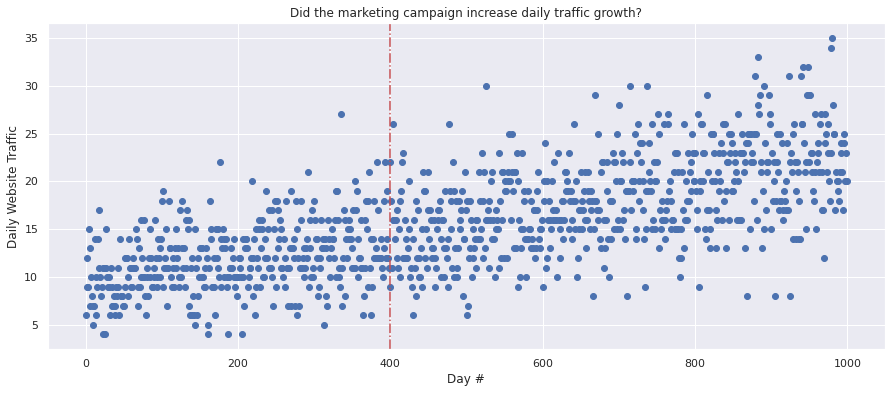

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.scatter(np.arange(t), y)
plt.ylabel('Daily Website Traffic')
plt.xlabel('Day #')
ax.axvline(400, color='r', linestyle='-.')
plt.title('Did the marketing campaign increase daily traffic growth?');
plt.savefig('campaign.png', dpi=300)

In [ ]:
avg_rate = np.mean(y)
idx = np.arange(len(y))

### Defining the model

With PyMC3, we define how data is created by linking probability distributions and mathematical functions together. In human terms we hypothesize:


*   The rate of website traffic started at some initial value theta
*   Traffic was initially growing at some constant rate "a"
*   At some switch point tau, the growth rate changed
*   Traffic was then growing at a second, different constant rate "b"
*   The rate of web traffic is our initial rate plus the sum of growth increments
*   Our expected number of views per day comes from a poisson distribution parameterized by our traffic rate per day  


We need to translate the human language into the language of math. We can write it out here:

$$\begin{align*}
\theta_{0}&\sim \text{Exponential}(\text{rate}=\alpha) \qquad \rightarrow \text{inital rate}\\
\text{growth}_{a} &\sim \text{Exponential}(\text{rate}=\beta) \qquad \rightarrow \text{initial growth rate}\\
\tau &\sim \text{Uniform}[0,1000) \qquad \rightarrow \text{change point}\\
\text{growth}_{b} &\sim \text{Exponential}(\text{rate}=\beta) \qquad \rightarrow \text{second growth rate}\\
\text{growth}_i &= \begin{cases} \text{growth}_{a}, & \tau < i \\ 
\text{growth}_{b}, & \text{otherwise}\end{cases} \\
\theta_i &= \theta_{0} + \sum_{i=0}^{n} \text{growth}_i \qquad \rightarrow \text{traffic rate at time i}\\
\text{Views}_i &\sim \text{Poisson}(\text{rate}=\theta_i) \qquad \rightarrow \text{views at time i}\\
\end{align*}$$


We translate this mathematical expression almost directly into PyMC3 syntax below


In [ ]:
with pm.Model() as m:

    # define priors
    # Since we're not sure what the initial rate of website traffic is,
    # we need to take a guess. In Bayesian statistics, our guesses aren't 
    # single values but distributions of values
    initial_rate = pm.Exponential('initial_rate', lam=1/avg_rate)

    # we do the same thing for our growth variables
    growth0 = pm.Exponential('growth0', 50)
    growth1 = pm.Exponential('growth1', 50)

    # we define our switchpoint. Here we don't assume it occurs at exactly
    # t = 400
    switchpoint = pm.DiscreteUniform('tau', lower=0, upper=len(y), testval=500)
    growth = switch(switchpoint < idx, growth0, growth1)

    # We need to calculate our instantaneous view rate 
    theta = pm.Deterministic('theta', 
                               T.extra_ops.cumsum(growth) + initial_rate)
    
    ## Define Poisson likelihood
    liklihood = pm.Poisson('y', theta, observed=y)

We can also visualize our data generation process!

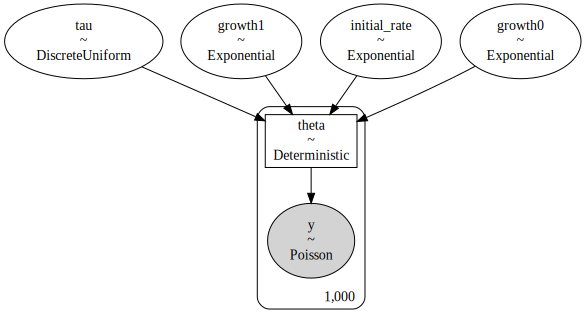

In [ ]:
pm.model_to_graphviz(m)

Here I just redefine the model a touch for computational efficiency. 

-- Aside --

For those interested, we're reparametizing the discrete switchpoint tau to use a sigmoid function instead. The NUTS sampler requires that the posterior space is continuosly differential for HMC to work. The discrete switchpoint introduces a discontinuity in the gradient, so we need to remove that. If we don't, the sampler uses the less efficient metropolis hastings algorithm to sample our taus and NUTS for the other parameters. 

We also need to parameterize the second growth rate as a delta, or an increase in growth. So, we swap to a half normal distribution (we could use a dist with support in the negative numbers to represent a decrease in growth rates, but we're *very confident* that our marketing team increased traffic growth.)

As to why, well because this problem only introduces a slight change in our growth rate, we wind up getting not great results unless our sampler is able to explore efficiently.

-- End Aside -- 

In [ ]:
def logistic(L, x0, k=500, t=np.linspace(0., 1., 1000)):
    return L/(1+T.exp(-k*(t-x0)))

with pm.Model() as m:

    # define priors, weakly informative Normal
    initial_rate = pm.Exponential('initial_rate', lam=1/avg_rate)
    growth0 = pm.Exponential('growth0', 50)
    growth1 = pm.HalfNormal('growth1', sd=0.01)

    theta = pm.Deterministic('theta', 
                              initial_rate + T.extra_ops.cumsum(growth0 +
                                              logistic(growth1, 0.4)))
    
    # Define Poisson likelihood. Note that we assign the actual observed data
    # here
    liklihood = pm.Poisson('y', theta, observed=y)

Now, we just click our "magic inference button" by calling the sample function. This uses our specified data generation process to find what parameters could have plausibly led to us to see the data that we did. We generate 2000 sets of parameters which could have led to the data we've seen.

The trace that we produce is the parameters used to generate data for our 2000 samples. Parameters that are more likely show up more frequently. 

In [ ]:
with m:
  trace = pm.sample(2000, tune=2000, progressbar=True, target_accept=0.9)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [growth1, growth0, initial_rate]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can plot the parameters that gave rise to the data according to our data generation story. The distribution of parameters tells us what the most likely possibilities were

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


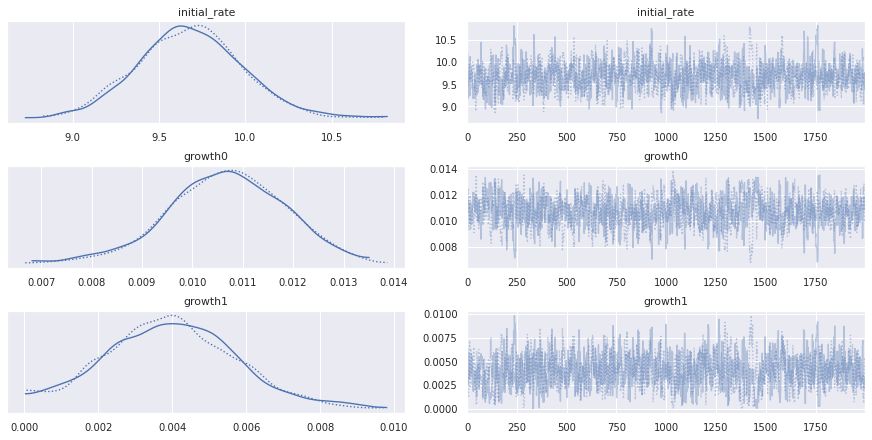

In [ ]:
pm.traceplot(trace, var_names=['initial_rate', 'growth0', 'growth1']);

What we see above is the distribution of parameters sampled from the posterior. This is what our updated beliefs about our parameters are after running our sampler. We see that the initial web traffic rate was a bit less than the true value of 10 (probably because the model is accounting for some extra growth). 

We also see that our model has our initial growth rate as about 1% per day, fairly confidently between .9% and 1.2%

For our growth1 parameter, which is the *increase* in growth, we have a lot less certainty. It could be anywhere from no change (0) to an increase of 1%, but probably around 0.4%

The two line styles represent the sampling distribution from two different chains. MCMC uses dependent sampling - we draw samples based on the last sample we drew. In order to diagnose issues around convergence and increase our effective number of samples, we typically draw samples in parallel from multiple chains. Each chain runs on a core of your machine. So here, in google collab, we get 2 chains. On a different machine, we may have more chains when we have more cores available.

We want to see that each chain has converged to (about) the same posterior. That is, the lines should overlap nicely showing that they were getting similar results. If they are vastly different, we probably have issues with our sampling and are not efficiently exploring our probability space. 

We want to see a nice "fuzzy caterpillar" on the right hand charts. That shows that the sampler is efficiently exploring the posterior spaces. If you see the sampler getting stuck and flatlining out, that could be due to a misspecified model or areas of high curvature. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

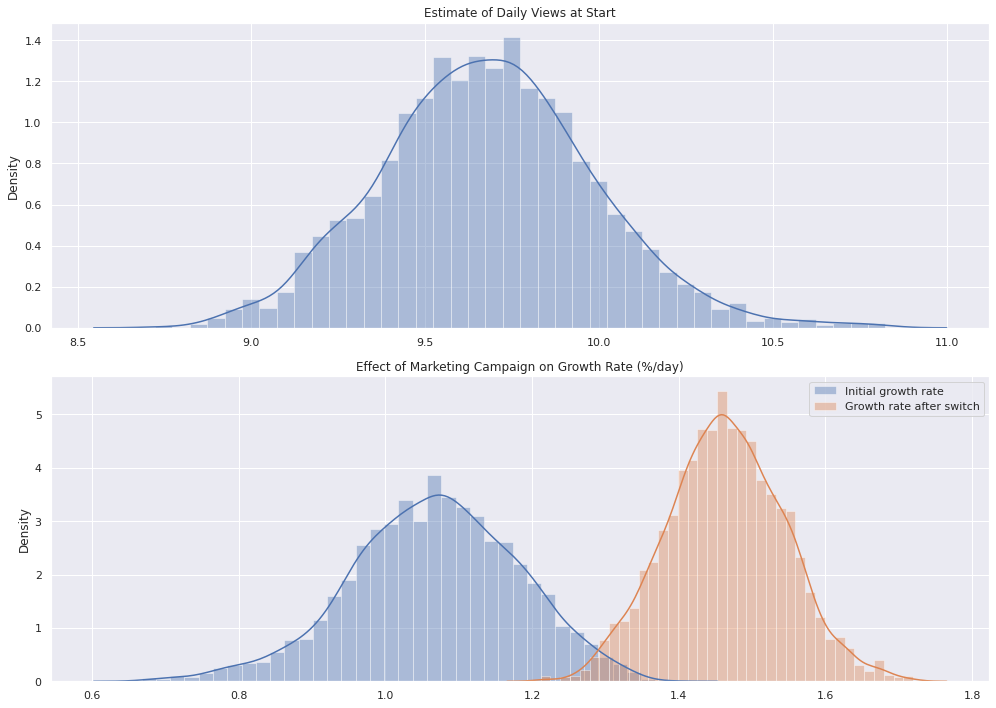

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
sns.distplot(trace['initial_rate'], ax=ax1)
sns.distplot(trace['growth0'] * 100, ax=ax2, label='Initial growth rate')
sns.distplot(trace['growth0'] * 100 + trace['growth1'] * 100, ax=ax2, label='Growth rate after switch')

ax1.set_title('Estimate of Daily Views at Start')
ax2.set_title('Effect of Marketing Campaign on Growth Rate (%/day)')
ax2.legend()
plt.tight_layout()

In [ ]:
trace['theta'][::100].shape

(40, 1000)

So, we can be fairly (but not 100%) confident that our marketing campaign increased web traffic growth!

Let's plot what the model is estimating our underlying growth rate to be

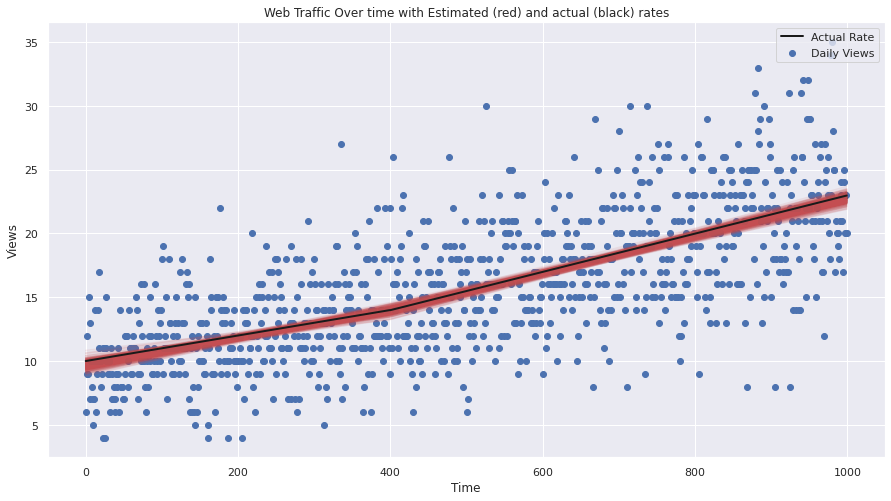

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(range(t), y, label='Daily Views')
ax.plot(trace['theta'][::10].T, alpha=.1, color='r')
ax.plot(theta_t, label='Actual Rate', color='k', linewidth=2);
ax.set(title='Web Traffic Over time with Estimated (red) and actual (black) rates', xlabel='Time', ylabel='Views')
ax.legend(loc='upper right');

Note what we accomplished: we came in with a story about how our data was generated. We turned that story into a mathematical model. We then translated that story almost verbatim into a PyMC3 model. We hit our "magical inference button" and saw how our data story could be mapped onto reality!

Now this is a data success story you can bring to your CEO.